In [5]:
%pip install numpy pandas matplotlib seaborn ipython jupyterlab Pillow pyscreenshot tensorflow scikit-learn keras-tuner


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\Alejo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [30]:
import numpy as np

o_player_sequences, d_player_sequences = np.load("../data/trajectoriesfull.npy",allow_pickle=True)

### Padding Model Input Array

Here we use the built in preprocessing function "pad_sequences" to pad our sequences to a uniform length. Above, we demonstrated a 43 frame sequence corresponding to the tracking data for a given play and player in a game. However, sequences in our dataframe will not always be this length due to the varying duration of football plays. Therefore, we add this preprocessing step to ensure our sequences are of an equal length to feed them into our model. The value that we are using to pad the sequences is an array of size 12 (same size as the elements of the sequence as shown above) with entries of -1 (Should this be changed?). We also specify that the padding values will be added to the end of each sequence, since we will be standardizing plays to start at a particular number of frames before our ball_snap event. Here we show the same entry as above after padding.

In [31]:
print(d_player_sequences[0])

[[2.5700000000000003, -0.8499999999999943, 295.95], [2.5900000000000034, -0.8699999999999974, 292.69], [2.6600000000000037, -0.8699999999999974, 295.02], [2.6899999999999977, -0.8799999999999955, 299.08], [2.740000000000002, -0.9199999999999946, 298.24], [2.8299999999999983, -0.9699999999999989, 302.62], [2.9399999999999977, -1.0599999999999952, 305.78], [3.0900000000000034, -1.1699999999999946, 308.08], [3.270000000000003, -1.3299999999999983, 309.95], [3.5, -1.5499999999999972, 308.9], [3.75, -1.779999999999994, 307.96], [4.060000000000002, -2.039999999999999, 305.31], [4.410000000000004, -2.309999999999995, 311.93], [4.829999999999998, -2.6099999999999994, 338.09], [5.25, -2.9099999999999966, 341.84], [5.75, -3.2099999999999937, 344.74], [6.300000000000004, -3.509999999999998, 345.66], [6.880000000000003, -3.809999999999995, 347.02], [7.5, -4.089999999999996, 350.41], [8.14, -4.359999999999999, 349.77], [8.800000000000004, -4.619999999999997, 354.7], [9.450000000000003, -4.859999999

In [32]:
d_player_sequences_dense = []
for seq in d_player_sequences:
    new_seq = [[x[0],x[1]] for x in seq]
    d_player_sequences_dense.append(new_seq)
print(d_player_sequences_dense[0])
print(len(d_player_sequences_dense))

[[2.5700000000000003, -0.8499999999999943], [2.5900000000000034, -0.8699999999999974], [2.6600000000000037, -0.8699999999999974], [2.6899999999999977, -0.8799999999999955], [2.740000000000002, -0.9199999999999946], [2.8299999999999983, -0.9699999999999989], [2.9399999999999977, -1.0599999999999952], [3.0900000000000034, -1.1699999999999946], [3.270000000000003, -1.3299999999999983], [3.5, -1.5499999999999972], [3.75, -1.779999999999994], [4.060000000000002, -2.039999999999999], [4.410000000000004, -2.309999999999995], [4.829999999999998, -2.6099999999999994], [5.25, -2.9099999999999966], [5.75, -3.2099999999999937], [6.300000000000004, -3.509999999999998], [6.880000000000003, -3.809999999999995], [7.5, -4.089999999999996], [8.14, -4.359999999999999], [8.800000000000004, -4.619999999999997], [9.450000000000003, -4.859999999999999], [10.100000000000001, -5.059999999999995], [10.71, -5.25], [11.300000000000004, -5.43], [11.810000000000002, -5.6299999999999955], [12.29, -5.82], [12.71, -6.

In [33]:
#from sklearn.preprocessing import StandardScaler
import tensorflow as tf 

#scaler = StandardScaler()
#scaled_o_seq = scaler.fit_transform(o_player_sequences)
#scaled_d_seq = scaler.fit_transform(d_player_sequences)

padding_value = [-1.0 for i in range(len([o_player_sequences[0][0]]))]
padded_o_seq = tf.keras.preprocessing.sequence.pad_sequences(o_player_sequences,padding='post', value=padding_value, dtype='float32',maxlen = 90)
#padded_expanded_seq = tf.expand_dims(padded_o_seq, -1)
masking_layer = tf.keras.layers.Masking(mask_value=-1)
masked_o_seq = masking_layer(padded_o_seq)
print(masked_o_seq.shape)

padding_value = [-1.0 for i in range(len([d_player_sequences_dense[0][0]]))]
padded_d_seq = tf.keras.preprocessing.sequence.pad_sequences(d_player_sequences_dense,padding='post', value=padding_value, dtype='float32',maxlen = 90)
#padded_expanded_seq = tf.expand_dims(padded_d_seq, -1)
masking_layer = tf.keras.layers.Masking(mask_value=-1)
masked_d_seq = masking_layer(padded_d_seq)
print(masked_d_seq.shape)

(43840, 90, 9)
(43840, 90, 2)


In [34]:
print(f"Number of Padded Defensive Sequences: {len(padded_d_seq)}")
print(f"Number of Padded Offensive Sequences: {len(padded_o_seq)}")

Number of Padded Defensive Sequences: 43840
Number of Padded Offensive Sequences: 43840


In [35]:
num_sequences = len(padded_o_seq)
num_train_sequences = int(num_sequences * 0.7)
dataset = tf.data.Dataset.from_tensor_slices((masked_o_seq, masked_d_seq))
train_dataset = dataset.take(num_train_sequences)
test_dataset = dataset.skip(num_train_sequences)
test_dataset_sample = test_dataset.take(1)
#print(list(test_dataset_sample))

batch_size = 64
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)
print(train_dataset_batched.element_spec)
print(test_dataset_batched.element_spec)


(TensorSpec(shape=(None, 90, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 90, 2), dtype=tf.float32, name=None))
(TensorSpec(shape=(None, 90, 9), dtype=tf.float32, name=None), TensorSpec(shape=(None, 90, 2), dtype=tf.float32, name=None))


### Creating the Model

In [36]:
import tensorflow as tf



input_shape = (batch_size, 90,len(o_player_sequences[0][0]))
output_shape = len(padded_d_seq[0][0])

#masking_layer = tf.keras.layers.Masking(mask_value=-1)

model = tf.keras.Sequential([
  #masking_layer,
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LSTM(352, input_shape=input_shape, return_sequences=True),#
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.LSTM(160, input_shape=input_shape, return_sequences=True),
  #tf.keras.layers.LSTM(160, input_shape=input_shape, return_sequences=True),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(output_shape)
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')

model.fit(train_dataset_batched, epochs=30)
loss = model.evaluate(test_dataset_batched)
print("Loss on test dataset: ", loss)

Epoch 1/30
480/480 [==============================] - 135s 275ms/step - loss: 0.6220
Epoch 2/30
480/480 [==============================] - 132s 276ms/step - loss: 0.4651
Epoch 3/30
480/480 [==============================] - 134s 278ms/step - loss: 0.4384
Epoch 4/30
480/480 [==============================] - 142s 296ms/step - loss: 0.4220
Epoch 5/30
480/480 [==============================] - 146s 305ms/step - loss: 0.4109
Epoch 6/30
480/480 [==============================] - 141s 295ms/step - loss: 0.4020
Epoch 7/30
480/480 [==============================] - 141s 294ms/step - loss: 0.3950
Epoch 8/30
480/480 [==============================] - 141s 295ms/step - loss: 0.3885
Epoch 9/30
480/480 [==============================] - 143s 297ms/step - loss: 0.3841
Epoch 10/30
480/480 [==============================] - 142s 296ms/step - loss: 0.3804
Epoch 11/30
480/480 [==============================] - 143s 298ms/step - loss: 0.3773
Epoch 12/30
480/480 [==============================] - 141s 294

In [38]:
model.save('../models/LSTMModel2LayerFull.h5')

In [15]:
model = tf.keras.models.load_model('./LSTMModel2LayerFull.h5')

1/1 [==============================] - 1s 574ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


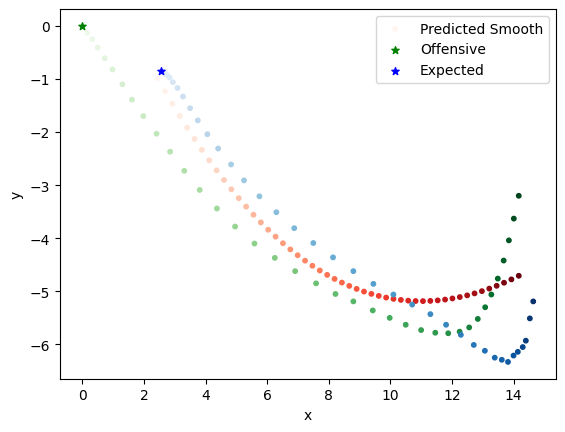



------------------------------------------ Normal Predicted Curve ------------------------------------------


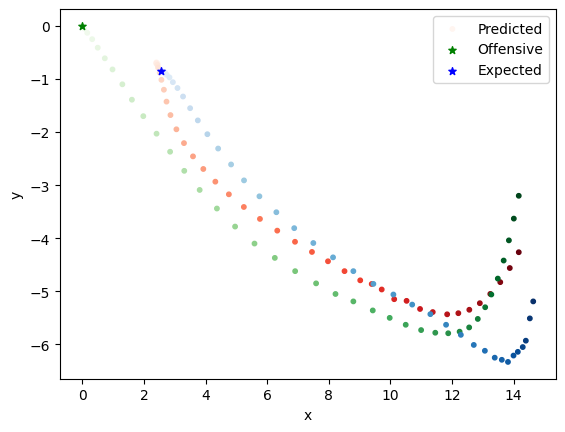

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 19ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


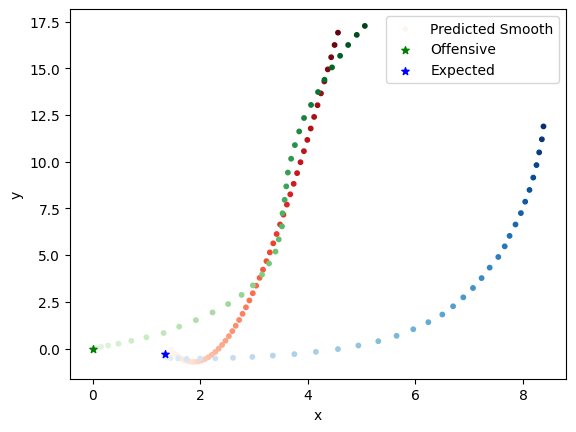



------------------------------------------ Normal Predicted Curve ------------------------------------------


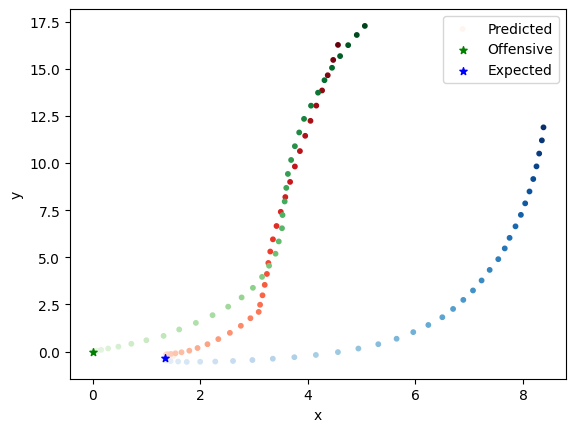

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


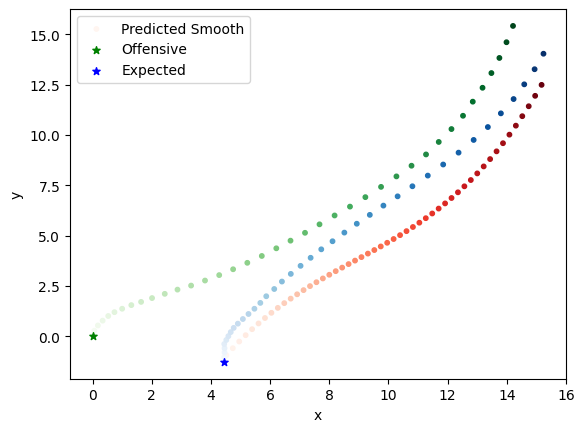



------------------------------------------ Normal Predicted Curve ------------------------------------------


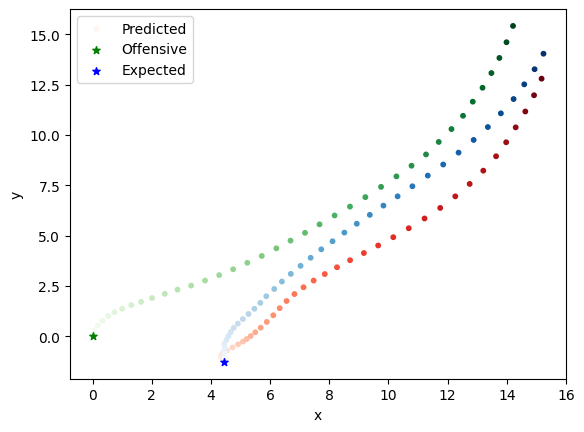

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 19ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


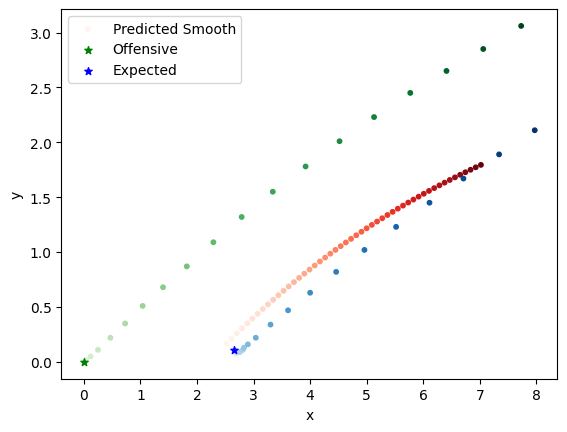



------------------------------------------ Normal Predicted Curve ------------------------------------------


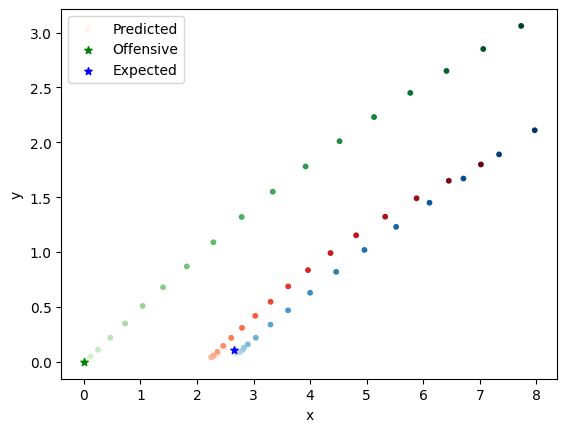

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 32ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


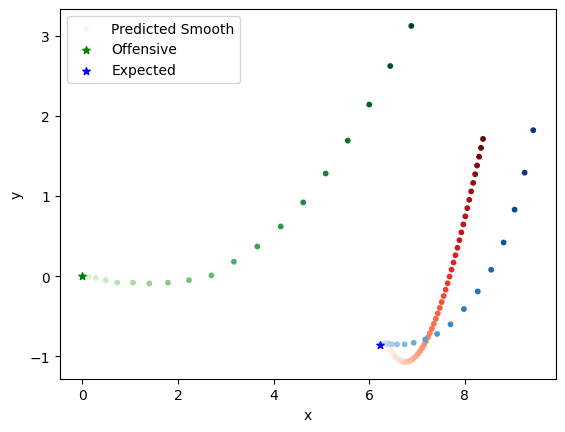



------------------------------------------ Normal Predicted Curve ------------------------------------------


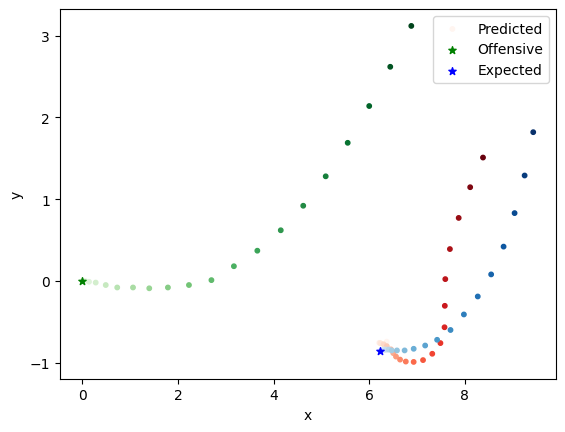

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


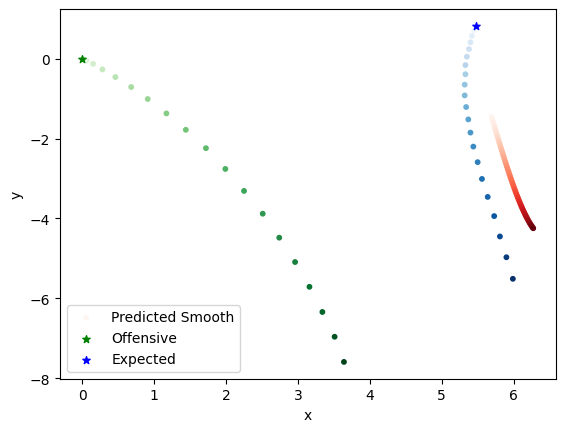



------------------------------------------ Normal Predicted Curve ------------------------------------------


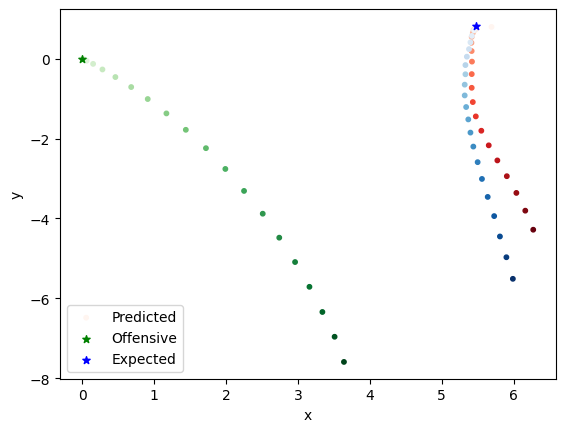

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


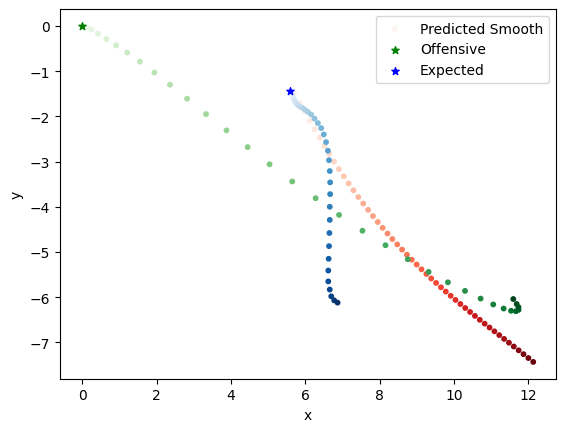



------------------------------------------ Normal Predicted Curve ------------------------------------------


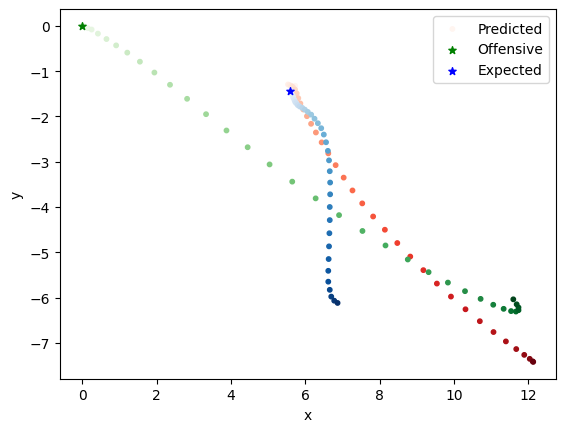

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


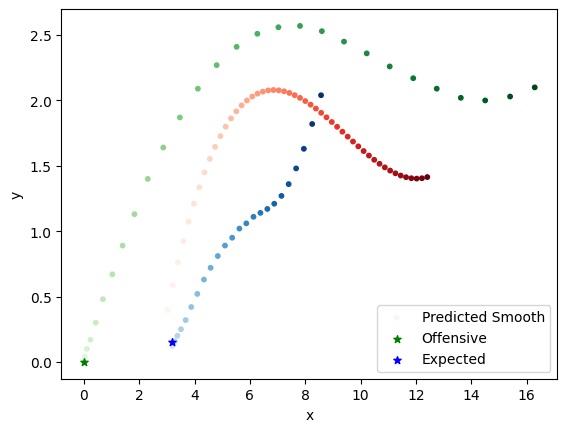



------------------------------------------ Normal Predicted Curve ------------------------------------------


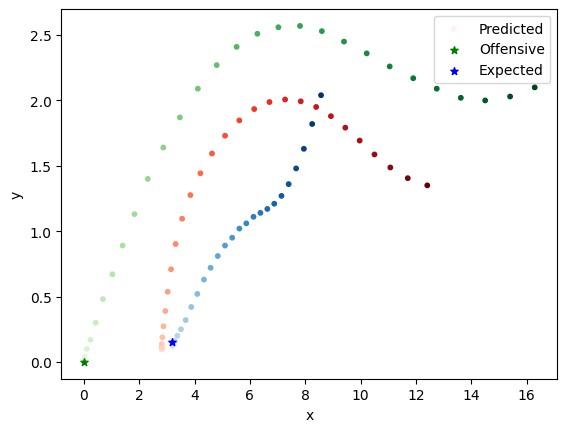

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 19ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


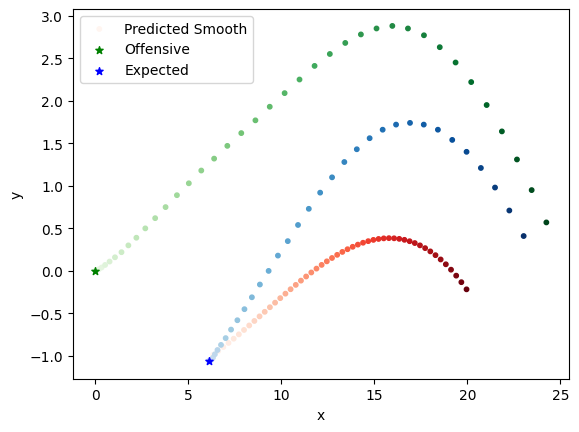



------------------------------------------ Normal Predicted Curve ------------------------------------------


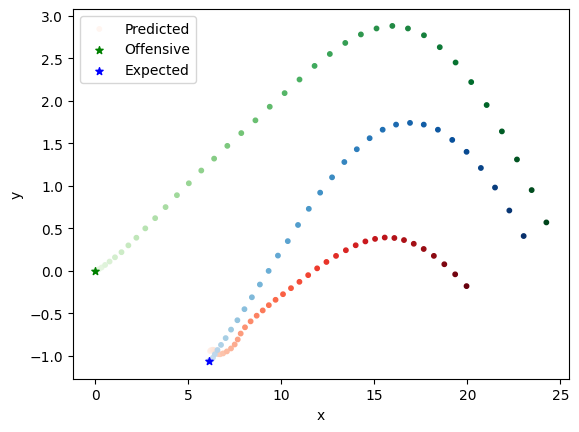

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


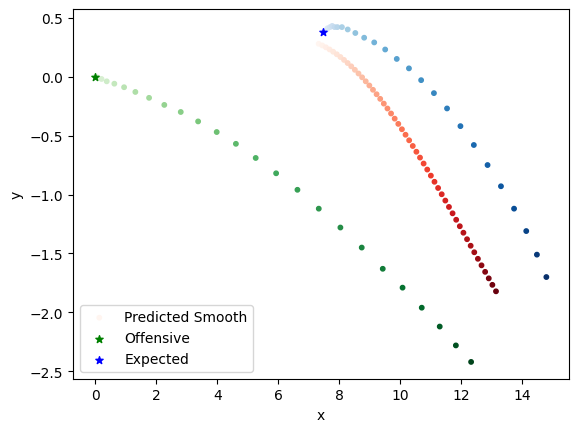



------------------------------------------ Normal Predicted Curve ------------------------------------------


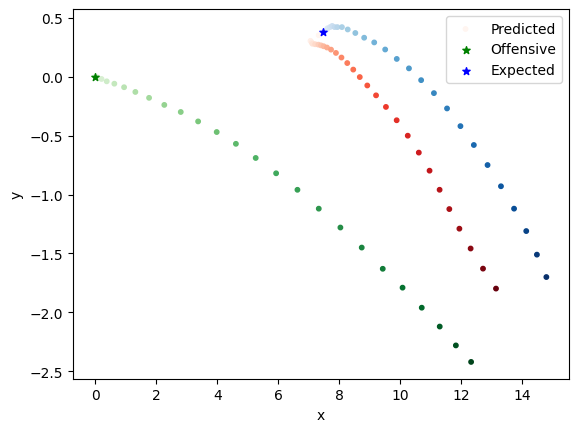

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 17ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


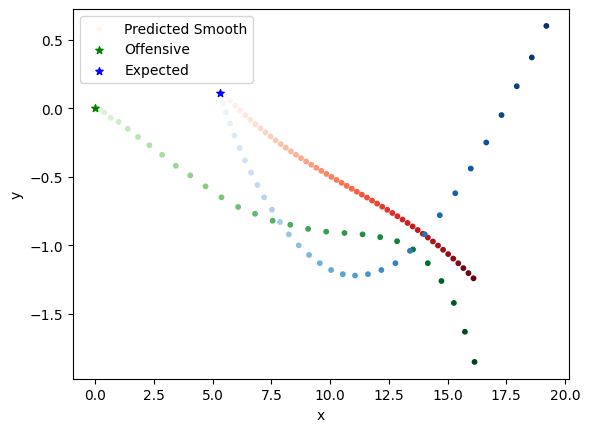



------------------------------------------ Normal Predicted Curve ------------------------------------------


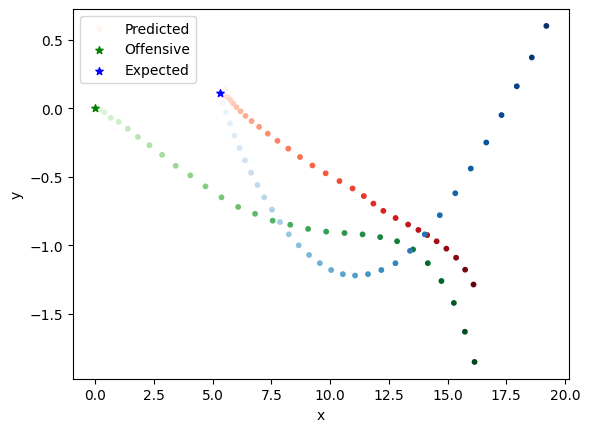

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 17ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


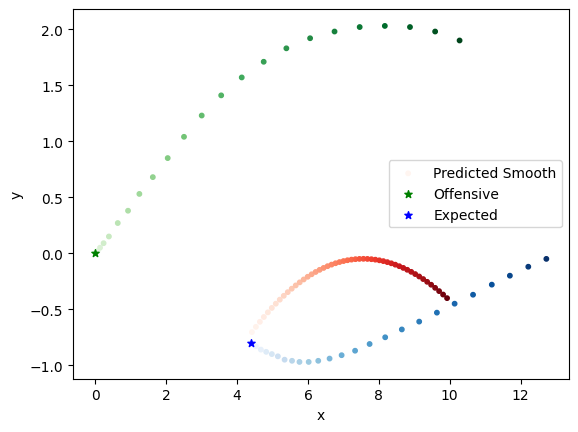



------------------------------------------ Normal Predicted Curve ------------------------------------------


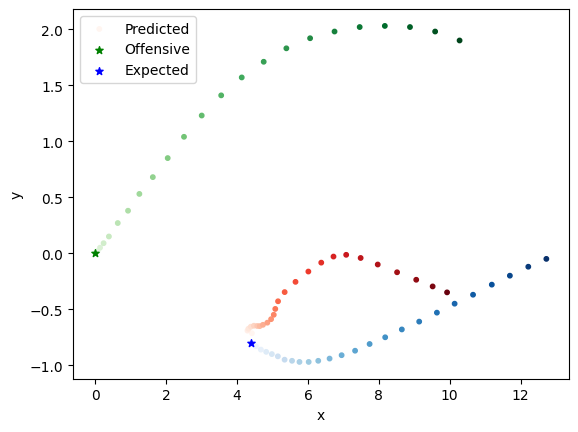

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


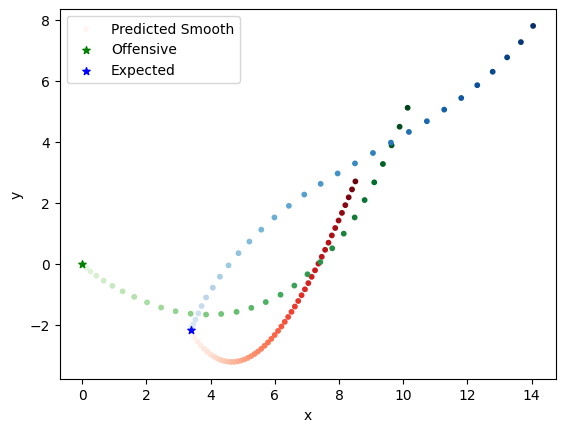



------------------------------------------ Normal Predicted Curve ------------------------------------------


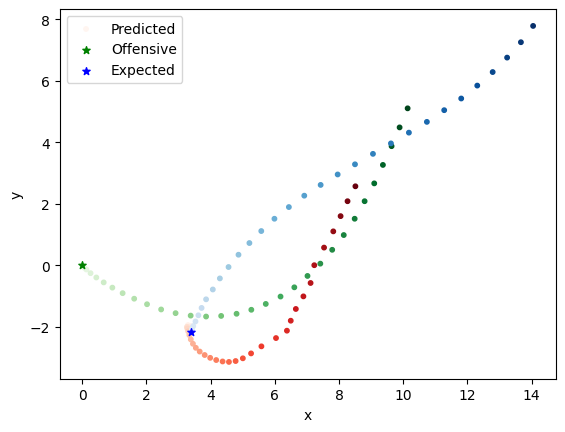

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 19ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


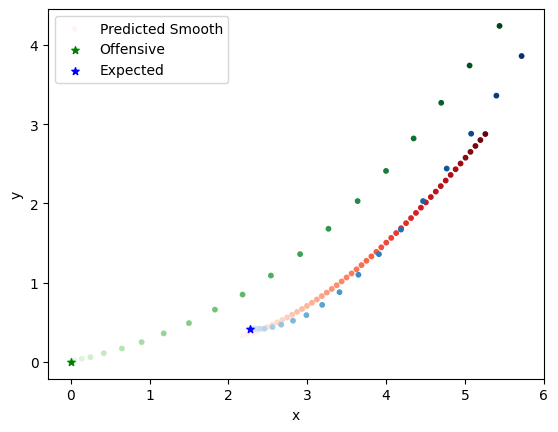



------------------------------------------ Normal Predicted Curve ------------------------------------------


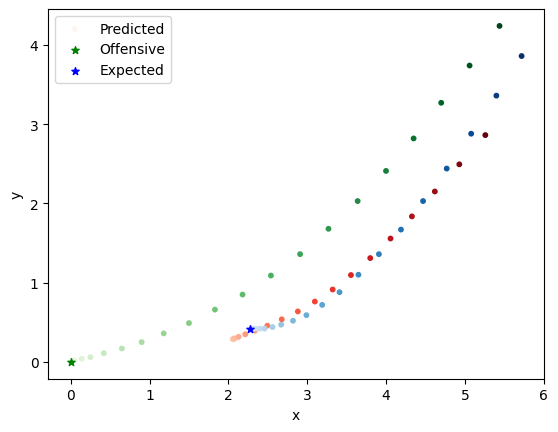

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


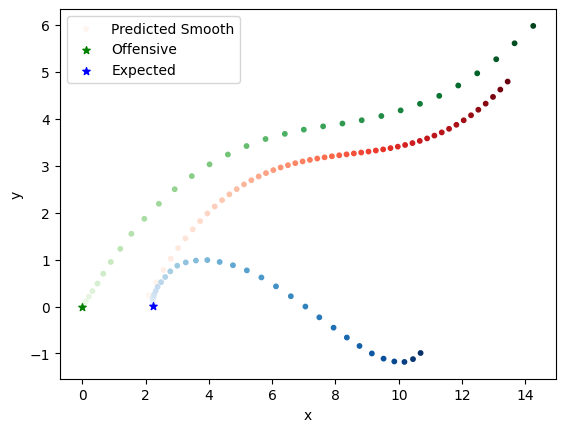



------------------------------------------ Normal Predicted Curve ------------------------------------------


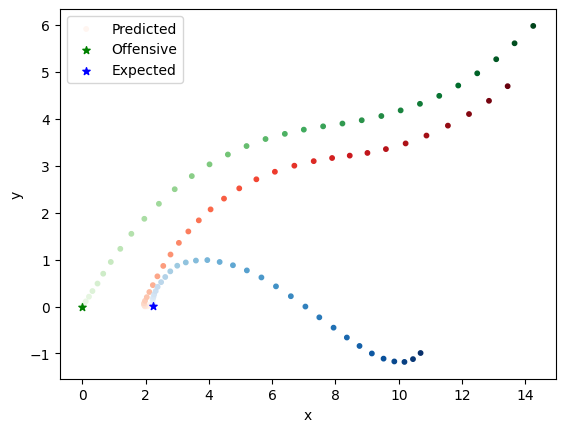

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 19ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


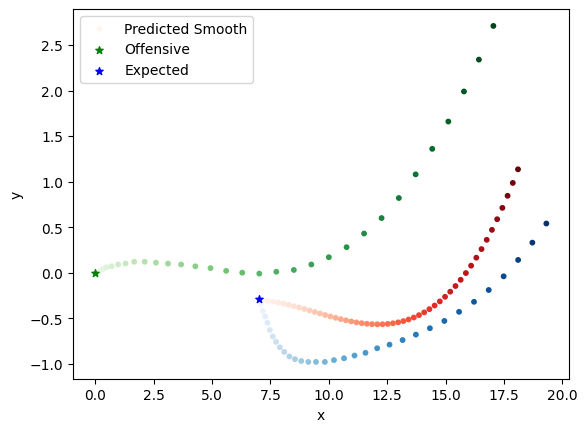



------------------------------------------ Normal Predicted Curve ------------------------------------------


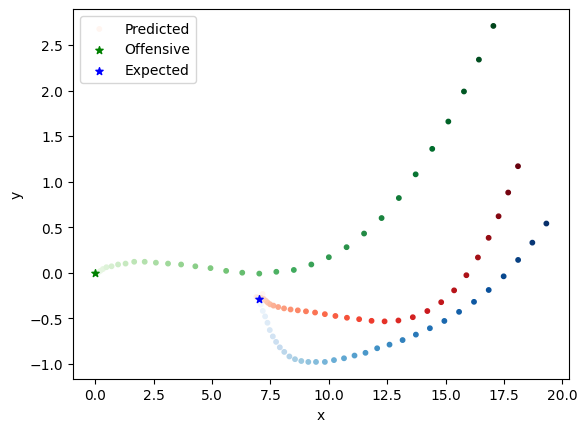

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


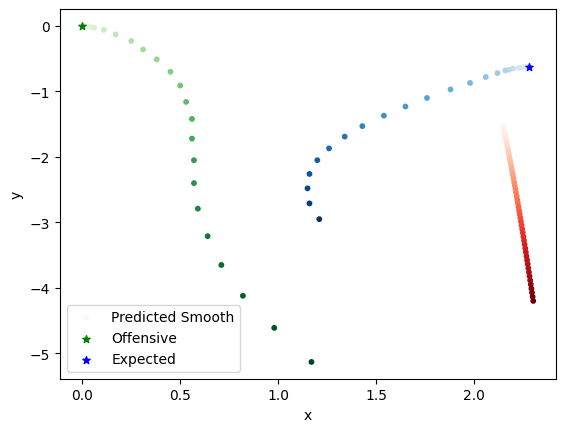



------------------------------------------ Normal Predicted Curve ------------------------------------------


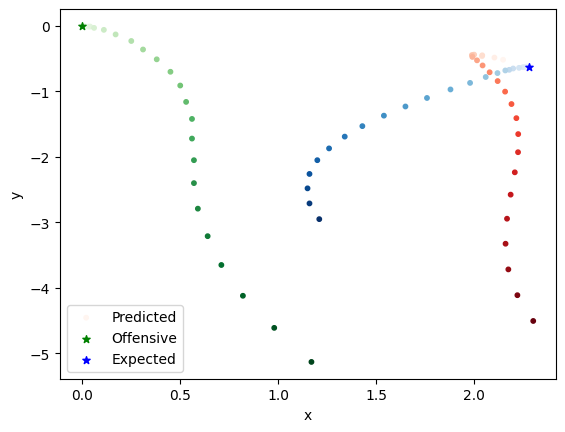

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 19ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


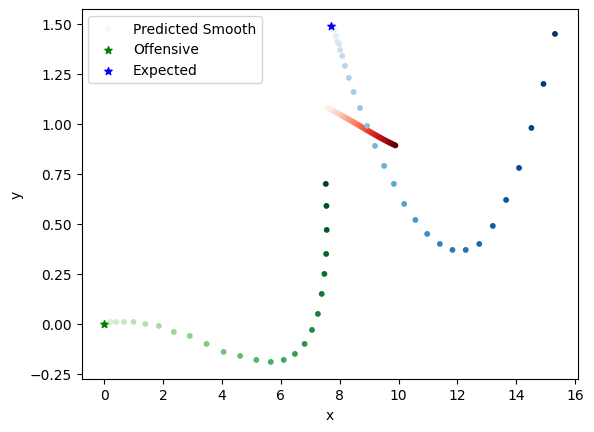



------------------------------------------ Normal Predicted Curve ------------------------------------------


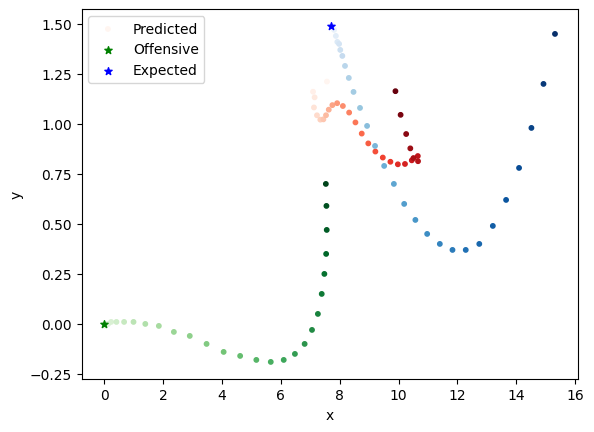

----------------------------------------------------------------------------------------------------------
1/1 [==============================] - 0s 18ms/step
------------------------------------------ Smooth Predicted Curve ------------------------------------------


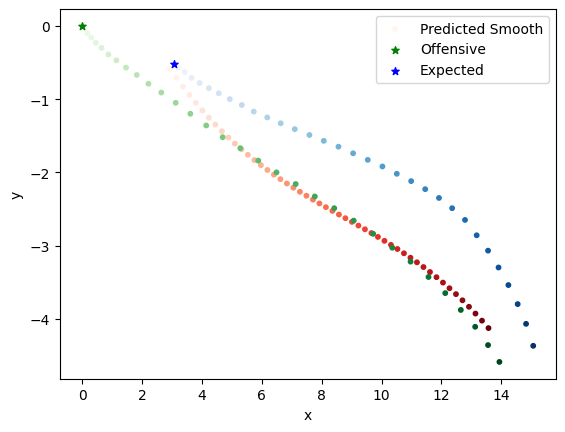



------------------------------------------ Normal Predicted Curve ------------------------------------------


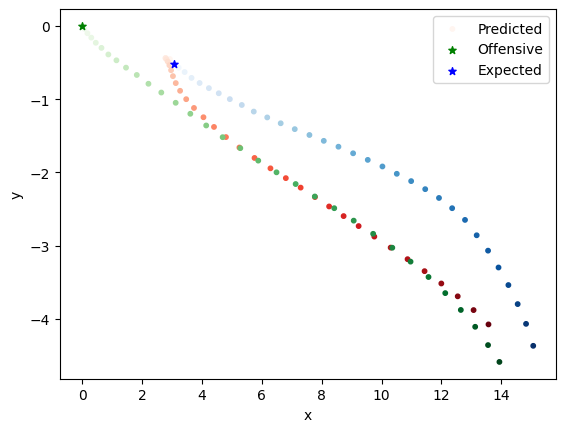

----------------------------------------------------------------------------------------------------------


ValueError: invalid literal for int() with base 10: ''

In [37]:
import matplotlib.pyplot as plt

max_length = len(masked_o_seq)
input_index = 0
while input_index!=-1:
    input_index = int(input(f"Enter an integer between 0 and {max_length} to compare sequence prediction vs actual"))
    o_sequence = masked_o_seq[input_index]
    o_sequence_len = len(o_player_sequences[input_index])
    #print(f"Input Offensive Sequence: {o_sequence[0]},{o_sequence[1]},{o_sequence[2]}")
    expected_sequence = masked_d_seq[input_index]
    predict_dataset = tf.data.Dataset.from_tensor_slices(([o_sequence], [expected_sequence]))
    predict_dataset_batched = predict_dataset.batch(1)

    #input_sequence = np.expand_dims(input_sequence,axis=(0,1))
    predicted_sequence = model.predict(predict_dataset_batched)
    predicted_sequence = predicted_sequence[0]
    #print(predicted_sequence)


    #print(f"Predicted Sequences: {predicted_sequence[0]},{predicted_sequence[1]},{predicted_sequence[2]}")

    predicted_sequence_x = [x[0] for x in predicted_sequence]
    predicted_sequence_y = [x[1] for x in predicted_sequence]

    predicted_sequence_x = predicted_sequence_x[0:o_sequence_len]
    predicted_sequence_y = predicted_sequence_y[0:o_sequence_len]

    z = np.polyfit(predicted_sequence_x, predicted_sequence_y, 3)
    f = np.poly1d(z)

    # calculate new x's and y's
    x_new = np.linspace(predicted_sequence_x[0], predicted_sequence_x[-1], 50)
    y_new = f(x_new)


    expected_sequence_x = [x[0] for x in expected_sequence ]
    expected_sequence_y = [x[1] for x in expected_sequence ]

    expected_sequence_x = expected_sequence_x[0:o_sequence_len]
    expected_sequence_y = expected_sequence_y[0:o_sequence_len]

    offensive_sequence_x = [x[0] for x in o_sequence]
    offensive_sequence_y = [x[1] for x in o_sequence]

    offensive_sequence_x = offensive_sequence_x[0:o_sequence_len]
    offensive_sequence_y = offensive_sequence_y[0:o_sequence_len]
    #print("\n\n")
    #print(predicted_sequence_x)
    #print("\n\n")
    #print(predicted_sequence_y)


    #print(f"Expected Sequence: {expected_sequence}\n\n")
    #print(f"Predicted Sequence: {predicted_sequence}\n\n")
    predicted_smooth_c = np.linspace(0, 1, len(x_new))
    predicted_c = np.linspace(0, 1, len(predicted_sequence_x))
    #print(predicted_c)
    expected_c = np.linspace(0, 1, len(expected_sequence_x))
    offensive_c = np.linspace(0, 1, len(offensive_sequence_x))

    #plt.scatter(xnew,y_smooth,s=10,color='r',label='Predicted Smooth')

    print("------------------------------------------ Smooth Predicted Curve ------------------------------------------")

    #plt.scatter(predicted_sequence_x,predicted_sequence_y,c=predicted_c,s=10,cmap="Reds")
    plt.scatter(x_new,y_new,label="Predicted Smooth",c=predicted_smooth_c,s=10,cmap='Reds')
    plt.scatter(offensive_sequence_x,offensive_sequence_y,c=offensive_c,s=10,cmap="Greens")
    plt.scatter(expected_sequence_x,expected_sequence_y,c=expected_c,s=10,cmap="Blues")

    #plt.scatter(x_new[0],y_new[0],color="",s=30,marker='*')

    plt.scatter(offensive_sequence_x[0],offensive_sequence_y[0],color="g",s=30,marker='*',label="Offensive")
    plt.scatter(expected_sequence_x[0],expected_sequence_y[0],color="b",s=30,marker='*',label="Expected")

    #plt.ylim([-15, 15])
    #plt.xlim([-15, 15])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

    print("\n\n------------------------------------------ Normal Predicted Curve ------------------------------------------")

    plt.scatter(predicted_sequence_x,predicted_sequence_y,label="Predicted",c=predicted_c,s=10,cmap='Reds')
    plt.scatter(offensive_sequence_x,offensive_sequence_y,c=offensive_c,s=10,cmap="Greens")
    plt.scatter(expected_sequence_x,expected_sequence_y,c=expected_c,s=10,cmap="Blues")

    #plt.scatter(x_new[0],y_new[0],color="",s=30,marker='*')

    plt.scatter(offensive_sequence_x[0],offensive_sequence_y[0],color="g",s=30,marker='*',label="Offensive")
    plt.scatter(expected_sequence_x[0],expected_sequence_y[0],color="b",s=30,marker='*',label="Expected")

    #plt.ylim([-15, 15])
    #plt.xlim([-15, 15])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    print("----------------------------------------------------------------------------------------------------------")


In [30]:
print(padded_o_seq[20][10][8])
print(padded_o_seq[20][10][9])


53.75
0.45


### Hyperparameter Tuning

In [42]:
import keras_tuner as kt

input_shape = (batch_size, 90,len(padded_o_seq[0][0]))
output_shape = len(padded_d_seq[0][0])

def build_model(hp):
    model = tf.keras.Sequential(
        [tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LSTM(hp.Int('units1', min_value=160, max_value=416, step=32),
        input_shape=input_shape, return_sequences=True),
        tf.keras.layers.Dropout(hp.Float('dropout1',min_value = 0.1,max_value = 0.3,step=0.05)),
        tf.keras.layers.LSTM(hp.Int('units2', min_value=160, max_value=416, step=32), return_sequences=True,input_shape=input_shape),
        tf.keras.layers.Dropout(hp.Float('dropout2',min_value = 0.1,max_value = 0.3,step=0.05)),
        tf.keras.layers.Dense(output_shape)
        ]
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [2e-2,1e-2, 1e-3])), loss='mae')
    return model


tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=30,
                     factor=3,
                     directory='LSTM2Layer2IF',
                     project_name='LSTM2Layer2IF')

tuner.search(train_dataset_batched, epochs=25, validation_data=test_dataset_batched)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 90 Complete [00h 22m 13s]
val_loss: 0.3209233582019806

Best val_loss So Far: 0.30617645382881165
Total elapsed time: 08h 28m 49s
INFO:tensorflow:Oracle triggered exit


### View Best Model Architecture

In [43]:
best_model.build(input_shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (64, 90, 11)             44        
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (64, 90, 352)             512512    
                                                                 
 dropout (Dropout)           (64, 90, 352)             0         
                                                                 
 lstm_1 (LSTM)               (64, 90, 160)             328320    
                                                                 
 dropout_1 (Dropout)         (64, 90, 160)             0         
                                                                 
 dense (Dense)               (64, 90, 2)               322       
                                                        

In [44]:
hp = tuner.get_best_hyperparameters()[0]
print(hp.values)

{'units1': 352, 'dropout1': 0.20000000000000004, 'units2': 160, 'dropout2': 0.30000000000000004, 'learning_rate': 0.001, 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


### View Best Hyperparameters

In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print(best_hyperparameters.values)

{'units1': 320, 'units2': 288, 'dropout': 0.20000000000000004, 'learning_rate': 0.01, 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [ ]:
### Make changes to the best_model
### Check model architecture => model.summary()

#best_model.add(tf.keras.layers.Dense(64, activation='relu'))
#best_model.layers[1].units = 256
#best_model.compile(optimizer='adam', loss='mae')

#best_model.fit(train_dataset_batched, epochs=25)
loss = best_model.evaluate(test_dataset_batched)
print("Loss on test dataset: ", loss)

81/81 [==============================] - 6s 55ms/step - loss: 18.4915
Loss on test dataset:  18.491544723510742


In [ ]:
best_model.save('LSTMModel2Layer.h5')

In [ ]:
model = tf.keras.models.load_model('LSTMModel.h5')